In [1]:
from datasets import load_from_disk

# Load the dataset
dataset_dict = load_from_disk('/home/grenders95/710/710_project/data/training/hf_datasets/newreqs_clearedfields')

# Access the individual splits from the loaded DatasetDict
train_dataset = dataset_dict['train']
eval_dataset = dataset_dict['validation']
test_dataset = dataset_dict['test']

In [5]:
print(train_dataset)
print(eval_dataset)
print(test_dataset)

Dataset({
    features: ['org_repo_name', 'requirements', 'sbom', 'mod_manifest_newreqs', 'num_dependencies', 'sbom_data_cleared', '__index_level_0__'],
    num_rows: 1822
})
Dataset({
    features: ['org_repo_name', 'requirements', 'sbom', 'mod_manifest_newreqs', 'num_dependencies', 'sbom_data_cleared', '__index_level_0__'],
    num_rows: 304
})
Dataset({
    features: ['org_repo_name', 'requirements', 'sbom', 'mod_manifest_newreqs', 'num_dependencies', 'sbom_data_cleared', '__index_level_0__'],
    num_rows: 532
})


In [2]:
# Model info for tokenizer

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "codellama/CodeLlama-7b-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map={"": "cuda"})


KeyboardInterrupt: 

In [6]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_eos_token=True,
    add_bos_token=True, 
)

In [7]:
def tokenize(prompt):
    result = tokenizer(prompt)
    result["labels"] = result["input_ids"].copy()
    return result

In [8]:
def generate_and_tokenize_full_prompt(data_point):
    # Constructing the instruction to include the target manifest directly
    instruction = f"The following is a target manifest file that describes properties and dependencies of a python repository:\n\n### Target manifest:\n{data_point['mod_manifest_newreqs']}\n\nCreate an SPDX SBOM based on the target manifest.\n\n### SPDX SBOM:"
    
    # Wrapping the complete instruction with CodeLlama's prompt format
    codellama_instruction = f"<s>[INST] {instruction} [/INST]</s>"
    
    full_prompt = f"""{codellama_instruction}

{data_point["sbom_data_cleared"]}
"""
    return tokenize(full_prompt)


In [9]:
def generate_and_tokenize_prompt(data_point):
    # Constructing the instruction to include the target manifest directly
    instruction = f"The following is a target manifest file that describes properties and dependencies of a python repository:\n\n### Target manifest:\n{data_point['mod_manifest_newreqs']}\n\nCreate an SPDX SBOM based on the target manifest.\n\n### SPDX SBOM:"
    
    # Wrapping the complete instruction with CodeLlama's prompt format
    codellama_instruction = f"<s>[INST] {instruction} [/INST]</s>"
    
    prompt = f"""{codellama_instruction}

"""
    return tokenize(prompt)

In [10]:
# Tokenize test set for training and inference prompts
tokenize_full_prompt_test = test_dataset.map(generate_and_tokenize_full_prompt)
tokenize_prompt_test = test_dataset.map(generate_and_tokenize_prompt)

In [3]:
import matplotlib.pyplot as plt
import os

def plot_data_lengths(tokenized_dataset, output_dir, filename):
    lengths = [(x['input_ids'], x['org_repo_name']) for x in tokenized_dataset]
    
    lengths.sort(key=lambda x: len(x[0]), reverse=True)

    # Calculate average length
    avg_length = sum(len(x[0]) for x in lengths) / len(lengths)
    print("Average Length:", avg_length)

    print("Organization Names of the Three Highest Length Input IDs:")
    for i in range(3):
        print(f"{i+1}. {lengths[i][1]}")

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist([len(x[0]) for x in lengths], bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.axvline(avg_length, color='red', linestyle='dashed', linewidth=1, label=f'Average Length: {avg_length:.2f}')
    plt.legend()

    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save the figure with the specified filename to the output directory
    full_path = os.path.join(output_dir, filename)
    plt.savefig(full_path)
    plt.close() 


In [14]:
plot_data_lengths(tokenize_full_prompt_test, '/home/grenders95/710/710_project/data/eval', 'newreqsfull_trainprompt_token_testset.png')

Average Length: 5540.571428571428
Organization Names of the Three Highest Length Input IDs:
1. galaxyproject_galaxy
2. pymedusa_medusa
3. mage-ai_mage-ai


In [15]:
plot_data_lengths(tokenize_prompt_test, '/home/grenders95/710/710_project/data/eval', 'newreqs_testprompt_testset_tokens.png')

Average Length: 256.2142857142857
Organization Names of the Three Highest Length Input IDs:
1. galaxyproject_galaxy
2. h2oai_h2o-llmstudio
3. mage-ai_mage-ai


/home/grenders95/miniconda3/envs/sme_project/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


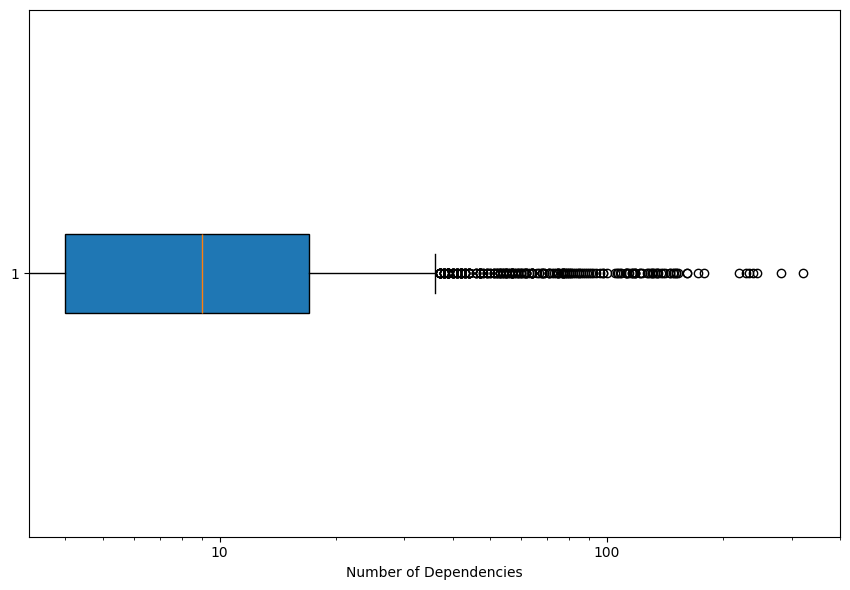

In [4]:
from datasets import concatenate_datasets
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
import matplotlib.gridspec as gridspec

all_datasets = concatenate_datasets([train_dataset, eval_dataset, test_dataset])
num_dependencies = np.array(all_datasets['num_dependencies'])  

# Compute statistics
mean = np.mean(num_dependencies)
median = np.median(num_dependencies)
mode = int(np.bincount(num_dependencies).argmax())
q1 = np.percentile(num_dependencies, 25)
q3 = np.percentile(num_dependencies, 75)
min_value = np.min(num_dependencies)
max_value = np.max(num_dependencies)

# Calculate the Interquartile Range (IQR) to determine non-outlier range
iqr = q3 - q1
upper_bound = q3 + (1.5 * iqr)
non_outlier_max = max([x for x in num_dependencies if x <= upper_bound])

# Calculate the percentile of the maximum non-outlier value
percentile_non_outlier_max = percentileofscore(num_dependencies, non_outlier_max)

# Create a figure with custom size & layout
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[5, 2])

ax1 = plt.subplot(gs[0])
ax1.boxplot(num_dependencies, vert=False, patch_artist=True)
ax1.set_xscale('log')
ax1.get_xaxis().set_major_formatter(plt.ScalarFormatter())

ax1.set_xlabel("Number of Dependencies")

plt.tight_layout()
plt.show()


In [8]:
import numpy as np

def create_varied_subset(tokenized_dataset, num_samples=25):
    filtered_dataset = [
        x for x in tokenized_dataset 
        if x['requirements'] is not None and 'torch' not in x['requirements']
    ]
    
    dependencies = np.array([x['num_dependencies'] for x in filtered_dataset])
    
    # Calculate quartiles
    q1 = np.percentile(dependencies, 25)
    q2 = np.percentile(dependencies, 50)
    q3 = np.percentile(dependencies, 75)
    
    # Divide the dataset into quartiles
    first_quartile_indices = np.where(dependencies <= q1)[0]
    second_quartile_indices = np.where((dependencies > q1) & (dependencies <= q2))[0]
    third_quartile_indices = np.where((dependencies > q2) & (dependencies <= q3))[0]
    fourth_quartile_indices = np.where(dependencies > q3)[0]
    
    samples_per_quartile = num_samples // 4
    remainder = num_samples % 4
    
    safe_sample_indices = lambda indices, n: np.random.choice(indices, min(len(indices), n), replace=False) if len(indices) > 0 else np.array([])
    
    selected_indices = np.concatenate([
        safe_sample_indices(first_quartile_indices, samples_per_quartile + (1 if remainder > 0 else 0)),
        safe_sample_indices(second_quartile_indices, samples_per_quartile + (1 if remainder > 1 else 0)),
        safe_sample_indices(third_quartile_indices, samples_per_quartile + (1 if remainder > 2 else 0)),
        safe_sample_indices(fourth_quartile_indices, samples_per_quartile),
    ])
    
    np.random.shuffle(selected_indices)
    
    selected_indices = selected_indices.tolist()
    
    varied_subset = [filtered_dataset[i] for i in selected_indices]
    
    return varied_subset

In [9]:
varied_subset = create_varied_subset(test_dataset, 25)

In [10]:
import pandas as pd
df = pd.DataFrame(varied_subset)

# Save the DataFrame as a CSV file
csv_filename = '/home/grenders95/710/710_project/data/eval/repos_to_test_subset.csv'
df.to_csv(csv_filename, index=False)